> ### IL
> SU  
> PR45  
> Modèle de Heston stationnaire

---

# Table des matières

* [Contexte](#Contexte)
* [Librairies](#Librairies)
* [Simulation](#Simulation)
    * [Euler vs Milstein](#Euler-vs-Milstein)
    * [BCIR](#BCIR)

In [ ]:
## Attention il faut inclure q

# Contexte

Le modèle de Heston souffre notoirement de problèmes de calibration mais aussi d’incohérences entre
maturités courte et longue en termes de smile. L’une des raisons est son surparamétrage et l’autre ( ?) le
fait que la volatilité partant généralement d’une valeur déterministe, le processus (CIR) de la volatilité a
deux régimes : initial à court terme et stationnaire à long terme. Nous proposons de surmonter ce problème
en considérant directement un modèle de Heston à volatilité stationnaire. L’accent sera
mis sur le pricing d’options vanille, la calibration (sous hypothèse de Feller) sur données hitoriques et le
pricing d’options exotiques (path-dependent) par simulation et/ou par quantification

\begin{equation*}
    \begin{cases}
    \operatorname{d}\! S_t = r S_t \operatorname{d}\! t + \sqrt{v_t} S_t \operatorname{d}\! W^S_t, & S_0 > 0 \\
    \operatorname{d}\! v_t = (a - \lambda v_t) \operatorname{d}\! t + \sigma \sqrt{v_t} \operatorname{d}\! W^v_t, & v_0 > 0
    \end{cases}
\end{equation*}

\begin{equation*}
    \forall t \in [0,T], \quad \operatorname{cor}(W^S_t, W^v_t) = \rho
\end{equation*}

On suppose dans un premier temps que les paramètres $a > 0$, $\lambda > 0$ et $\sigma > 0$ avec $2 a > \sigma^2$.

Sous cette condition, le processus $(v_t)_{t \ge 0}$ reste strictement positif (avec probabilité 1).

# Librairies

In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set_theme()
from numpy.random import default_rng
rng = default_rng()
import pandas as pd

# Simulation

## Euler vs Milstein
Pour le path Milstein on écrit la volatilité V avec le shéma de Milstein et on reste en Euler pour le prix d'actif S: V s'écrit en fonction de sa racine carrée, donc le terme de correction est plus significatif et améliore la stabilité.

In [2]:
# Schéma d'Euler sur S et V
def paths_euler(S0,v0,rho,r,a,lambd,sigma,T,dW_dB):
    d, N, M = dW_dB.shape
    h = T / N
    S = S0 + np.zeros(shape=(N+1,M))
    v = v0 + np.zeros(shape=(N+1,M))
    dW, dB = dW_dB[0], dW_dB[1]
    dW_S = rho * dW + np.sqrt(1 - rho**2) * dB
    for k in range(1, N+1):
        S[k] = S[k-1] + r * S[k-1] * h + np.sqrt(v[k-1]) * S[k-1] * dW_S[k-1]
        v[k] = v[k-1] + (a - lambd * v[k-1]) * h + sigma * np.sqrt(v[k-1]) * dW[k-1]
        #v[k] = np.abs(v[k])
    return S, v

In [3]:
# Schéma d'Euler sur S, schéma de Milstein sur V
def paths_milstein(S0,v0,rho,r,a,lambd,sigma,T,dW_dB):
    d, N, M = dW_dB.shape
    h = T / N
    S = S0 + np.zeros(shape=(N+1,M))
    v = v0 + np.zeros(shape=(N+1,M))
    dW, dB = dW_dB[0], dW_dB[1]
    dW_S = rho * dW + np.sqrt(1 - rho**2) * dB
    for k in range(1, N+1):
        S[k] = S[k-1] + r * S[k-1] * h + np.sqrt(v[k-1]) * S[k-1] * dW_S[k-1]
        v[k] = v[k-1] + (a - lambd * v[k-1]) * h + sigma * np.sqrt(v[k-1]) * dW[k-1] + (sigma)**2 * (dW[k-1]**2 - h) /4.
        #v[k] = np.abs(v[k])
    return S, v

In [4]:
# Schéma d'Euler sur S, schéma de Milstein sur le BCIR y
def paths_BCIR_milstein(S0,v0,rho,r,a,lambd,sigma,T,dW_dB):
    d, N, M = dW_dB.shape
    h = T / N
    S = S0 + np.zeros(shape=(N+1,M))
    y = v0 + np.zeros(shape=(N+1,M))
    dW, dB = dW_dB[0], dW_dB[1]
    dW_S = rho * dW + np.sqrt(1 - rho**2) * dB
    for k in range(1, N+1):
        S[k] = S[k-1] + r * S[k-1] * h + np.sqrt(y[k-1]) * S[k-1] * dW_S[k-1]
        y[k] = y[k-1] + a * np.exp(lambd * k*h) * h + np.exp(lambd/2 * k*h) * sigma * np.sqrt(y[k-1]) * dW[k-1] +  np.exp(lambd * k*h) * (sigma)**2 * (dW[k-1]**2 - h) /4.
    return S, y

In [5]:
N = 50
M = 20

S0=100
v0=0.1
r=0.05
a=0.1
lambd=0.1
sigma=0.1
rho=0.3
T=1
h=T/N

In [6]:
dW_dB = np.sqrt(h) * rng.standard_normal(size = (2, N, M))
S,v = paths_euler(S0,v0,rho,r,a,lambd,sigma,T,dW_dB)
Sm,vm = paths_milstein(S0,v0,rho,r,a,lambd,sigma,T,dW_dB)

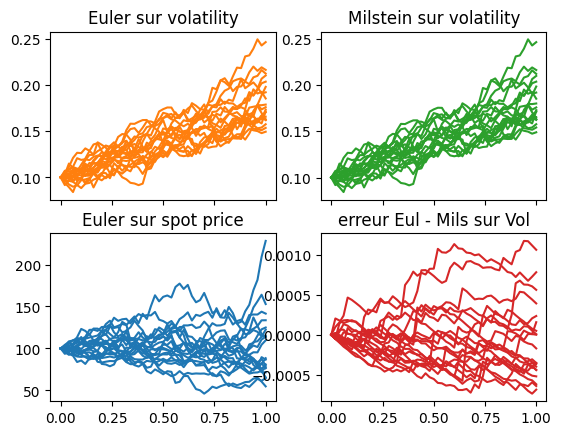

In [7]:
erreur = vm -v

time = h*np.arange(0, N+1)
fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True)
axs[0][0].set_title("Euler sur volatility")
axs[0][0].plot(time, v, color='C1')
axs[0][1].set_title("Milstein sur volatility")
axs[0][1].plot(time, vm, color='C2')
axs[1][0].set_title("Euler sur spot price")
axs[1][0].plot(time, S, color='C0')
axs[1][1].set_title("erreur Eul - Mils sur Vol")
axs[1][1].plot(time, erreur, color='C3')
plt.show()

20 trajectoires du spot et de la volatilité obtenues avec un schéma d'Euler de pas $h = \frac{1}{N}$ et $N = 50$.

In [8]:
#BCIR
B,y = paths_BCIR_milstein(S0,v0,rho,r,a,lambd,sigma,T,dW_dB)

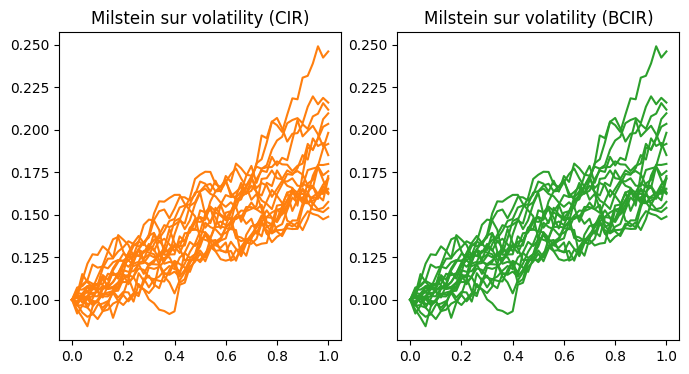

In [9]:
fig, axs = plt.subplots(nrows=1, ncols=2,figsize=(8,4))
axs[0].set_title("Milstein sur volatility (CIR)")
axs[0].plot(time, vm, color='C1')
axs[1].set_title("Milstein sur volatility (BCIR)")
vb = [np.exp(-0.1*time[i])*y[i] for i in range(len(time))]
axs[1].plot(time, vb, color='C2')
#axs[1].plot(time, y, color='C2')
plt.show()

In [10]:
#Etude de la variance
var_cir = np.var(v[-1])   # à l'instant final T
var_bcir = np.var(vb[-1])
print(f"Variance CIR: {var_cir:.6f}")
print(f"Variance Boosted CIR: {var_bcir:.6f}")


Variance CIR: 0.000607
Variance Boosted CIR: 0.000598


On remarque une augmentation légère de la variance

## Perfectionnement
Variable antithétique?

Dans la suite, on considère le schéma de Milstein sur le BCIR (plus stable) pour garantir la positivité sous la condition de Feller


On considère le Boosted CIR Process: $ y_t = \exp(\lambda t) \cdot v_t$ pour garantir la stricte positivité du schéma de Milstein

\begin{equation*}
    \begin{cases}
    \operatorname{d}\! S_t = r S_t \operatorname{d}\! t + \sqrt{v_t} S_t \operatorname{d}\! W^S_t, & S_0 > 0 \\
    v_t = \exp(-\lambda t)y_t , & v_0 > 0 \\
    \operatorname{d}\! y_t = \exp(\lambda t)a \operatorname{d}\! t + \exp(\lambda t/2)\sigma \sqrt{y_t} \operatorname{d}\! W^v_t
    \end{cases}
\end{equation*}

In [ ]:
#######################################################################################################################

## Smile, cas v0 fixé

In [11]:
from scipy.optimize import newton
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm


In [12]:
def bs_call_price(S, K, sigma, r, T):
    epsilon = 1e-10
    d1 = (np.log(S/K) + (r + sigma**2 / 2)*T) / (sigma * np.sqrt(T)+epsilon)
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)

In [13]:
# === Vega et Newton pour inversion
def Vega(S, K, sigma, r, T):
    epsilon = 1e-10
    d1 = (np.log(S/K) + (r + sigma**2 / 2)*T) / (sigma * np.sqrt(T)+epsilon)
    return S * np.sqrt(T) * norm.pdf(d1)

In [14]:
# Implied volatility using scipy's Newton method
def implied_vol(S, K, r, T, price, sigma_init=None):
    if sigma_init is None:
        F = S * np.exp(r*T)
        sigma_init = np.sqrt( 2/T * np.abs(np.log(F/K)))

    def objective(sigma):
        return bs_call_price(S, K, sigma, r, T) - price

    def vega(sigma):
        return Vega(S, K, sigma, r, T)

    implied_vol = newton(
        func=objective,
        x0=sigma_init,
        fprime=vega,
        tol=1e-6,
        maxiter=100,
    )
    return implied_vol

In [ ]:
'''def implied_vol(S, K, r, T, price, tol=1e-4, max_iter=100):
    epsilon = 1e-10
    F = S * np.exp(r*T)
    sigma = np.sqrt( 2/T * np.abs(np.log(F/K)))
    for _ in range(max_iter):
        price_est = bs_call_price(S, K, sigma, r, T)
        vega = Vega(S, K, sigma, r, T)
        sigma -= (price_est - price) / (vega)
        if abs(price_est - price) < tol:
            break
    return sigma
    '''

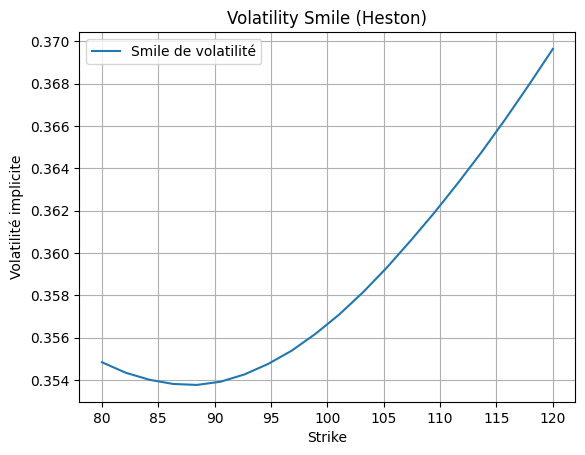

In [15]:
# === Simulation (Euler sur Heston)
def simulate_ST(X_params, N=100, M=100000):
    S0,v0,rho,r,a,lambd,sigma,T = X_params
    h = T / N
    rng = np.random.default_rng()
    dW_dB = np.sqrt(h) * rng.standard_normal((2, N, M))
    S, v = paths_milstein(S0,v0,rho,r,a,lambd,sigma,T,dW_dB)
    return S[-1]

# === Paramètres
S0 = 100
v0 = 0.1
r = 0.05
a = 0.1
lambd = 0.1
sigma = 0.5
rho = 0.2
#T=0.01
T = 1

X_params = (S0,v0,rho,r,a,lambd,sigma,T)
ST = simulate_ST(X_params, N=100, M=100000)

# === Smile
K_list = np.linspace(80, 120, 20)
vols = []

for K in K_list:
    payoffs = np.maximum(ST - K, 0)
    price_MC = np.exp(-r * T) * np.mean(payoffs)
    vol_imp = implied_vol(S0, K, r, T, price_MC)
    vols.append(vol_imp)

# === Plot
plt.plot(K_list, vols, label="Smile de volatilité")
plt.xlabel("Strike")
plt.ylabel("Volatilité implicite")
plt.title("Volatility Smile (Heston)")
plt.grid()
plt.legend()
plt.show()

## Smile, cas v0 ~ gamma

In [ ]:
#Dans la classe de heston:
#v = self.v0 + np.zeros((N+1, M))  # même v0 pour chaque trajectoire on réimplémente S et v:

On va injecter plus d'aléatoire dans la volatilié en maturité short, pour corriger le smile

In [ ]:
A = 3  + np.zeros((2, 2))
np.sqrt(A)

array([[1.73205081, 1.73205081],
       [1.73205081, 1.73205081]])

In [16]:
def simulate_ST_gamma(X_params, N=100, M=100000):
    S0, r, a, lambd, sigma, rho, T = X_params
    h = T / N
    rng = np.random.default_rng()
    dW_dB = np.sqrt(h) * rng.standard_normal((2, N, M))

    # Tirage de v0 pour chaque trajectoire (M échantillons Gamma)
    beta = 2 * lambd / sigma**2
    alpha = a * beta / lambd
    y0_samples = rng.gamma(alpha, 1 / beta, size=M)

    S = S0 + np.zeros((N+1, M))
    y = y0_samples.copy()
    all_v = np.zeros((N+1, M))
    all_v[0] = y

    dW, dB = dW_dB[0], dW_dB[1]
    dW_S = rho * dW + np.sqrt(1 - rho**2) * dB


    for k in range(1, N+1):
        y = y + a * np.exp(lambd * k*h) * h + np.exp(lambd/2 * k*h) * sigma * np.sqrt(y) * dW[k-1] +  np.exp(lambd * k*h) * (sigma)**2 * (dW[k-1]**2 - h) /4.
        v = y * np.exp(-lambd * k*h)
        all_v[k] = v
        S[k] = S[k-1] + r * S[k-1] * h + np.sqrt(v) * S[k-1] * dW_S[k-1]
    return S[-1]


In [17]:
X_prms = (S0, r, a, lambd, sigma, rho, T)
ST = simulate_ST_gamma(X_prms)

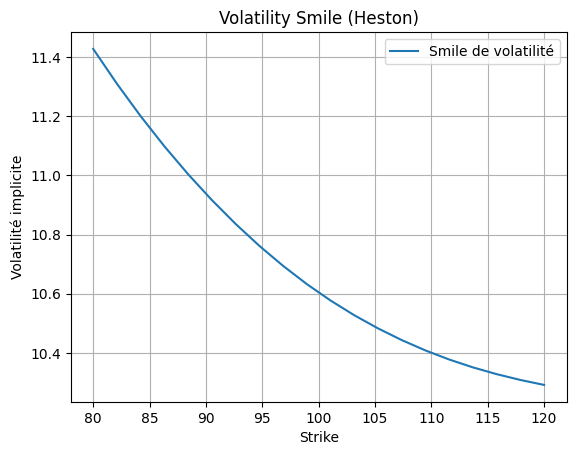

In [18]:
# === Smile
K_list = np.linspace(80, 120, 20)
vols = []
T=0.01
for K in K_list:
    payoffs = np.maximum(ST - K, 0)
    price_MC = np.exp(-r * T) * np.mean(payoffs)
    vol_imp = implied_vol(S0, K, r, T, price_MC)
    vols.append(vol_imp)

# === Plot
plt.plot(K_list, vols, label="Smile de volatilité")
plt.xlabel("Strike")
plt.ylabel("Volatilité implicite")
plt.title("Volatility Smile (Heston)")
plt.grid()
plt.legend()
plt.show()

In [ ]:
#simu de gamma a l'aide de la methode de rejet

In [19]:
import numpy as np

def sample_gamma_rejection(alpha, beta, M, rng=None):
    """
    Génère M échantillons selon la loi Gamma(alpha, beta) par la méthode du rejet.
    Utilise Marsaglia & Tsang pour alpha > 1, et une transformation pour alpha < 1.
    """
    if rng is None:
        rng = np.random.default_rng()

    samples = np.zeros(M)
    i = 0

    if alpha < 1:
        # Cas alpha < 1 : transformation via Gamma(alpha+1)
        while i < M:
            u = rng.random()
            x = sample_gamma_rejection(alpha + 1, beta, 1, rng)[0]
            sample = x * u**(1/alpha)
            samples[i] = sample
            i += 1
    else:
        # Marsaglia & Tsang (2000) pour alpha >= 1
        d = alpha - 1/3
        c = 1 / np.sqrt(9 * d)
        while i < M:
            z = rng.standard_normal()
            u = rng.random()
            v = (1 + c * z)**3
            if v > 0 and np.log(u) < 0.5 * z**2 + d - d * v + d * np.log(v):
                samples[i] = d * v / beta  # loi Gamma(alpha, beta)
                i += 1

    return samples


# MC

In [20]:
def monte_carlo(sample, proba=0.95):
    mean = np.mean(sample)
    var = np.var(sample, ddof=1)
    quantile = stats.norm.ppf(1 - (1-proba)/2)
    ci_size = quantile * np.sqrt(var / sample.size)
    result = { "mean": mean, "var": var, "lower": mean - ci_size, "upper": mean + ci_size }
    return result

## Call utilisant Euler

In [21]:
def call_heston_Milstein(S0,v0,rho,r,a,lambd,sigma,T, N, M = 20000):
    h = T / N
    dW_dB = np.sqrt(h) * rng.standard_normal(size = (2, N, M))
    S, v = paths_milstein(S0,v0,rho,r,a,lambd,sigma,T,dW_dB)
    K = 100
    payoffs = np.maximum(S[N] - K, 0)
    return monte_carlo(np.exp(-r * T) * payoffs)['mean']

In [22]:
call_heston_Milstein(S0,v0,rho,r,a,lambd,sigma,T, N, M = 20000)

np.float64(1.2878856959106793)

# Pricing Call sur Heston standard (Transformée de Fourier, formule de Carr-Madan)

$$
I_0 = E[f(v_0)] =  \int_0^\infty \frac{f(v) \cdot \beta^\alpha}{\Gamma(\alpha)} v^{\alpha - 1} e^{-\beta v} \, dv
$$


Quantization based quadrature formulas

On choisit d'approximer l'intégrale par "the quadrature formula from Laguerre polynomials"

Approximation:


$$
I_0^{(n)} \approx \frac{\beta^\alpha}{\Gamma(\alpha)} \sum_{i=1}^n \omega_i f(v_i) \tag{2.13}
$$

avec $( \omega_i)$ sont les poids de Laguerre et $ v_i$ les noeuds de Laguerre associés.


expliquer que le prix du call est = E[E[payoff/v]]=E[f(v)] donc f(v) est = l'esperance conditionnelle (donc heston conditionnel)

In [23]:
import numpy as np
from scipy.integrate import quad

def psi_function(u, params, S0, r, q, T):
    lambd, a, sigma, rho, v0 = params
    i = complex(0,1)
    epsilon = 1e-10 #Pour la gestion des erreurs de division par zero
    d = np.sqrt((rho * sigma * i * u - lambd)**2 + sigma**2 * (i * u + u**2))
    g = (lambd - rho * sigma * i * u - d) / (lambd - rho * sigma * i * u + d + epsilon)
    term1 = np.exp(i*u*(np.log(S0)+(r-q)*T))
    log_term = (1-g*np.exp(-d*T))/(1-g+epsilon)
    if log_term>0:
        term2 = np.exp(a/sigma**2*(T*(lambd-rho*sigma*u*i-d)-2*np.log(log_term)))
    else:
        term2 = np.exp(a/sigma**2*(T*(lambd-rho*sigma*u*i-d)))
    term3 = np.exp(v0**2/(sigma**2+epsilon)*(lambd-rho*sigma*u*i-d)*(1-np.exp(-d*T))/(1-g*np.exp(-d*T)+epsilon)) #v0 u lieu de v0**2? car explosion du prix sinon
    return term1*term2*term3

In [24]:
#Test de la fonction psi
params = 0.1,0.1,0.3,0,0.1
psi_function(3, params, 100, 0.01, 0.01, 1)
S0 = 275
r = 0.03
q = 0
T = 1

v_init = 0.04
lambd_init = 1.0
a_init = 0.04
sigma_init = 0.3
rho_init = -0.5

In [25]:
def integr_P1(u, params, S0, K, r, q, T):
    i = complex(0, 1)
    psi_P1 = psi_function(u - i, params, S0, r, q, T)
    complex_for_Re_P1 = np.exp(-i * u * np.log(K)) * psi_P1 / (i*u*S0*np.exp(r-q)*T)
    return np.real(complex_for_Re_P1)

def integr_P2(u, params, S0, K, r, q, T):
    i = complex(0, 1)
    psi_P2 = psi_function(u, params, S0, r, q, T)
    complex_for_Re_P2 = np.exp(-i * u * np.log(K)) * psi_P2 / (i*u)
    return np.real(complex_for_Re_P2)


In [26]:
print(integr_P1(3, params, S0, K, r, q, T))

0.1202835309913524


In [27]:
#def conditional_heston_call(v, S0, K, T, r, q, lambd, a, sigma, rho):
def conditional_heston_call(K, v, lambd, a, sigma, rho,S0, T, r, q):
    params = (lambd, a, sigma, rho, v)

    # Intégration en utilisant scipy.integrate.quad
    P1_integral, _ = quad(lambda u: integr_P1(u, params, S0, K, r, q, T), 1e-6, 100, limit=500) #quad returns result, error
    P2_integral, _ = quad(lambda u: integr_P2(u, params, S0, K, r, q, T), 1e-6, 100, limit=500)

    P1 = 0.5 + P1_integral / np.pi
    P2 = 0.5 + P2_integral / np.pi

    # Prix du call Heston conditionnellement à v
    call_price = S0 * np.exp(-q * T) * P1 - K * np.exp(-r * T) * P2
    return call_price

In [28]:
S0 = 100
K = 100
T = 1.0
r = 0.03
q = 0.0
lambd = 2.0
a = 0.1
sigma = 0.3
rho = -0.7
v = 0.04

In [29]:
price = conditional_heston_call(K, v, lambd, a, sigma, rho,S0, T, r, q)
print(f"Prix Call sur Heston conditionnel C = {price:.4f}")


Prix Call sur Heston conditionnel C = 8.1634


In [30]:
#pricing cas stationnaire à l'aide de heston

from scipy.special import gamma, roots_genlaguerre

# === Prix Heston via quadrature de Laguerre ===
def heston_price_laguerre(S0, K, T, r, q, lambd, a, sigma, rho, n=64):
    # Paramètres de la densité gamma stationnaire de v_t
    beta = 2 * lambd / sigma**2
    alpha = a * beta / lambd

    # Nœuds et poids Laguerre généralisés
    xi, wi = roots_genlaguerre(n, alpha - 1)
    vi = xi / beta  # car les noeuds générés par roots_genlaguerre correspondent à v**(alpha-1)*exp(-v)

    # on définit un tableau des f(vi)
    f_vi = np.array([conditional_heston_call(K, v, lambd, a, sigma, rho,S0, T, r, q) for v in vi])
    price = np.sum(wi * f_vi)/ gamma(alpha)
    return price

#A noter que la fct prend un parametre en moins qui est V0

In [31]:
heston_price_laguerre(S0, K, T, r, q, lambd, a, sigma, rho, n=100)

np.float64(8.253592535620832)

# Calibration

In [32]:
import pandas as pd

In [43]:
import pandas as pd

data = {
    "Strike":  [155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 355, 360, 365, 370, 375, 380, 385, 390, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 355, 360, 365, 370, 375, 380, 385, 390]
,
    "Bid": [157.68,152.68,147.68,142.68,137.68,132.68,127.68,122.68,117.68,112.68,107.68,102.68,97.69,92.69,87.69,82.7,77.7,72.71,67.71,62.72,57.73,52.74,47.75,42.78,41.78,40.77,39.78,38.78,37.79,36.8,35.8,34.81,33.81,32.82,31.82,30.83,29.84,28.85,27.87,26.88,25.9,24.91,23.94,22.97,21.99,21.02,20.06,19.1,18.15,17.21,16.26,15.34,14.41,13.5,12.65,11.75,10.88,10.02,9.23,8.4,7.59,6.81,6.06,5.35,4.65,4.01,3.4,2.85,2.34,1.89,1.51,1.18,0.92,0.71,0.52,0.39,0.29,0.21,0.16,0.12,0.09,0.07,0.05,0.04,0.03,0.02,0.02,0.01,0.01,0.01,0,0,0,0.01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.02,0.02,0.02,0.03,0.03,0.04,0.05,0.06,0.08,0.09,0.1,0.1,0.1,0.11,0.11,0.12,0.12,0.13,0.13,0.14,0.15,0.15,0.16,0.17,0.18,0.19,0.21,0.23,0.24,0.27,0.29,0.32,0.35,0.39,0.44,0.49,0.55,0.61,0.68,0.77,0.86,0.96,1.08,1.22,1.37,1.54,1.73,1.94,2.19,2.45,2.75,3.1,3.49,3.93,4.41,4.96,5.57,6.24,6.89,7.65,8.45,9.31,10.21,11.13,12.07,13.02,13.99,14.96,15.95,16.93,17.91,18.92,19.91,20.9,21.9,22.88,23.89,24.89,25.89,26.89,27.89,28.89,29.89,30.89,31.89,32.89,33.89,34.89,35.89,36.89,37.89,38.89,39.89,41.89,46.89,51.89,56.89,61.9,66.89,71.9,76.88]

,
    "Midpoint":  [157.9,152.9,147.9,142.9,137.94,132.9,127.9,122.91,117.91,112.9,107.91,102.91,97.91,92.91,87.92,82.93,77.92,72.93,67.93,62.95,57.95,52.96,47.97,42.99,41.99,40.99,40,39,38,37.02,36.02,35.03,34.03,33.04,32.04,31.05,30.06,29.07,28.09,27.09,26.11,25.12,24.15,23.17,22.2,21.23,20.27,19.3,18.34,17.4,16.45,15.53,14.59,13.68,12.78,11.88,11,10.13,9.29,8.46,7.65,6.86,6.1,5.38,4.69,4.04,3.44,2.88,2.37,1.92,1.54,1.2,0.94,0.72,0.54,0.4,0.3,0.22,0.17,0.13,0.1,0.08,0.06,0.05,0.04,0.03,0.03,0.02,0.02,0.02,0.01,0.01,0.01,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.03,0.03,0.03,0.04,0.04,0.05,0.06,0.07,0.08,0.1,0.11,0.11,0.11,0.11,0.11,0.13,0.13,0.14,0.14,0.15,0.16,0.16,0.17,0.18,0.19,0.2,0.22,0.24,0.25,0.28,0.3,0.33,0.36,0.4,0.45,0.5,0.56,0.63,0.7,0.79,0.88,0.98,1.1,1.23,1.39,1.56,1.75,1.96,2.21,2.48,2.78,3.14,3.53,3.97,4.46,5.01,5.62,6.29,7.03,7.82,8.64,9.5,10.41,11.33,12.28,13.23,14.2,15.18,16.17,17.15,18.13,19.14,20.13,21.12,22.12,23.1,24.11,25.11,26.11,27.11,28.11,29.11,30.11,31.11,32.11,33.11,34.11,35.11,36.11,37.11,38.11,39.11,40.11,42.11,47.11,52.11,57.11,62.11,67.11,72.12,77.1]
,
    "Ask":  [158.12,153.12,148.12,143.12,138.19,133.12,128.12,123.14,118.13,113.12,108.13,103.13,98.14,93.13,88.15,83.15,78.14,73.15,68.15,63.18,58.17,53.18,48.19,43.2,42.2,41.21,40.23,39.22,38.22,37.24,36.23,35.25,34.24,33.25,32.26,31.26,30.27,29.28,28.3,27.3,26.32,25.33,24.35,23.37,22.4,21.43,20.47,19.5,18.53,17.59,16.64,15.71,14.78,13.86,12.9,12.01,11.12,10.23,9.34,8.51,7.71,6.9,6.13,5.41,4.72,4.07,3.47,2.9,2.4,1.95,1.56,1.22,0.95,0.72,0.55,0.41,0.31,0.23,0.18,0.13,0.1,0.08,0.06,0.05,0.04,0.03,0.03,0.02,0.02,0.02,0.01,0.01,0.01,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.03,0.03,0.03,0.04,0.04,0.05,0.06,0.07,0.09,0.1,0.11,0.11,0.11,0.12,0.12,0.13,0.13,0.14,0.14,0.15,0.16,0.17,0.18,0.18,0.2,0.21,0.22,0.24,0.26,0.28,0.31,0.34,0.37,0.41,0.46,0.51,0.57,0.64,0.71,0.8,0.9,1,1.12,1.25,1.41,1.58,1.77,1.98,2.23,2.5,2.81,3.17,3.56,4.01,4.5,5.05,5.67,6.34,7.16,7.98,8.82,9.7,10.6,11.53,12.48,13.44,14.41,15.39,16.38,17.36,18.34,19.35,20.34,21.34,22.33,23.33,24.33,25.32,26.33,27.33,28.33,29.33,30.33,31.33,32.33,33.33,34.33,35.33,36.33,37.33,38.33,39.33,40.33,42.33,47.33,52.33,57.33,62.33,67.33,72.33,77.33]
,
    "IV":  [2.35,2.25,2.16,2.07,2,1.89,1.81,1.73,1.65,1.57,1.49,1.42,1.35,1.28,1.21,1.14,1.07,1.01,0.94,0.88,1.17,0.75,0.69,0.78,0.61,0.72,0.59,0.55,0.57,0.56,0.54,0.53,0.52,0.68,0.49,0.71,0.47,0.55,0.54,0.5,0.43,0.36,0.55,0.29,0.38,0.54,0.42,0.46,0.34,0.34,0.29,0.26,0.22,0.28,0.38,0.24,0.27,0.25,0.26,0.25,0.24,0.23,0.23,0.23,0.22,0.21,0.2,0.2,0.19,0.19,0.18,0.18,0.17,0.17,0.17,0.16,0.17,0.17,0.17,0.17,0.16,0.17,0.16,0.17,0.17,0.17,0.19,0.18,0.19,0.2,0.19,0.2,0.22,0.21,0.22,0.24,0.23,0.24,0.24,0.25,0.26,0,0.27,0.27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.23,1.13,1.08,1.03,1.03,0.98,0.87,0.88,0.83,0.81,0.76,0.71,0.66,0.63,0.6,0.57,0.52,0.49,0.44,0.44,0.43,0.43,0.41,0.41,0.4,0.4,0.39,0.38,0.37,0.36,0.36,0.35,0.35,0.34,0.33,0.32,0.31,0.31,0.3,0.3,0.29,0.28,0.28,0.27,0.27,0.27,0.26,0.25,0.25,0.24,0.24,0.23,0.23,0.22,0.22,0.21,0.2,0.2,0.19,0.18,0.18,0.17,0.16,0.16,0.15,0.19,0.19,0.17,0.1,0.18,0.23,0,0,0.04,0,0.1,0.11,0,0,0,0,0.11,0.23,0.11,0.1,0.1,0.09,0.09,0.23,0.07,0.05,0.04,0.23,0.31,0.32,0.32,0,0.32,0.32,0.31,0.31,0.31,0.3,0.28,0.22,0.14,0,0,0,0.74]
#,
    #"Type": ["Call"] * 126 + ["Put"] * 126
}



# Créer le DataFrame
df = pd.DataFrame(data)




ValueError: All arrays must be of the same length

In [38]:
L = [158.12, 153.12, 148.12, 143.12, 138.19, 133.12, 128.12, 123.14, 118.13, 113.12, 108.13, 103.13, 98.14,
            93.13, 88.15, 83.15, 78.14, 73.15, 68.15, 63.18, 58.17, 53.18, 48.19, 43.2, 42.2, 41.21, 40.23, 39.22,
            38.22, 37.24, 36.23, 35.25, 34.24, 33.25, 32.26, 31.26, 30.27, 29.28, 28.3, 27.3, 26.32, 25.33, 24.35,
            23.37, 22.4, 21.43, 20.47, 19.5, 18.53, 17.59, 16.64, 15.71, 14.78, 13.86, 12.9, 12.01, 11.12, 10.23,
            9.34, 8.51, 7.71, 6.9, 6.13, 5.41, 4.72, 4.07, 3.47, 2.9, 2.4, 1.95, 1.56, 1.22, 0.95, 0.72, 0.55, 0.41,
            0.31, 0.23, 0.18, 0.13, 0.1, 0.08, 0.06, 0.05, 0.04, 0.04, 0.03, 0.03, 0.02, 0.02, 0.02, 0.01, 0.01,
            0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0, 0, 0, 0, 0]
len(L)

108

In [ ]:
data.head()

In [ ]:
data = data.loc[:,['Strike', 'Bid', 'Midpoint', 'Ask',  'Type']]
data["Spread"] = (data.Ask - data.Bid)
data

,Strike,Bid,Midpoint,Ask,Type,Spread
0,160,174.31,174.48,174.65,Call,0.34
1,165,169.31,169.48,169.65,Call,0.34
2,170,164.30,164.48,164.65,Call,0.35
3,175,159.31,159.48,159.65,Call,0.34
4,180,154.30,154.48,154.65,Call,0.35
...,...,...,...,...,...,...
233,375,40.36,40.53,40.69,Put,0.33
234,380,45.37,45.53,45.68,Put,0.31
235,385,50.36,50.53,50.69,Put,0.33
236,390,55.36,55.52,55.68,Put,0.32


In [ ]:
CALL = data[data.Type=="Call"]
# PUT = data[data.Type=="Put"].reset_index(drop=True)
prices = CALL.Midpoint.values
strikes = CALL.Strike.values
spreads = CALL.Spread.values
payoff = "call"

In [ ]:
T=1

In [ ]:
print(prices)

[1.7448e+02 1.6948e+02 1.6448e+02 1.5948e+02 1.5448e+02 1.4948e+02
 1.4448e+02 1.3948e+02 1.3448e+02 1.2948e+02 1.2449e+02 1.1948e+02
 1.1448e+02 1.0949e+02 1.0449e+02 9.9490e+01 9.4490e+01 8.9490e+01
 8.4500e+01 7.9500e+01 7.4500e+01 6.9510e+01 6.4520e+01 6.0520e+01
 5.9550e+01 5.8530e+01 5.7550e+01 5.6530e+01 5.5540e+01 5.4540e+01
 5.3540e+01 5.2540e+01 5.1550e+01 5.0550e+01 4.9570e+01 4.8560e+01
 4.7550e+01 4.6530e+01 4.5600e+01 4.4560e+01 4.3540e+01 4.2560e+01
 4.1570e+01 4.0540e+01 3.9550e+01 3.8580e+01 3.7600e+01 3.6580e+01
 3.5590e+01 3.4620e+01 3.3600e+01 3.2580e+01 3.1650e+01 3.0670e+01
 2.9670e+01 2.8670e+01 2.7690e+01 2.6690e+01 2.5700e+01 2.4700e+01
 2.3730e+01 2.2780e+01 2.1810e+01 2.0840e+01 1.9850e+01 1.8900e+01
 1.7930e+01 1.6980e+01 1.6010e+01 1.5070e+01 1.4120e+01 1.3180e+01
 1.2270e+01 1.1340e+01 1.0430e+01 9.5700e+00 8.7000e+00 7.8500e+00
 7.0300e+00 6.2300e+00 5.4600e+00 4.7300e+00 4.0400e+00 3.4100e+00
 2.8300e+00 2.3200e+00 1.8700e+00 1.4800e+00 1.1600e+00 8.9000

In [ ]:
IV_mkt = [implied_vol(S0, K, r, T, price) for K, price in zip(strikes, prices)]

IV_mkt

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 5.851113871499366,
 4.171248093253313,
 3.6211662087279404,
 3.2612745113141623,
 2.9856639988343834,
 2.7590009358765264,
 2.5645584324584987,
 2.392311780202325,
 2.266173405903521,
 2.2369565023571267,
 2.2066341151148583,
 2.1780258102169654,
 2.148621269693912,
 2.1205480176171725,
 2.09256341710566,
 2.064950910325496,
 2.0376908398633753,
 2.011050390563113,
 1.984436742922725,
 1.9586817926609574,
 1.9323666400501947,
 1.9063235692051828,
 1.8802647895281144,
 1.8568792603054705,
 1.8307414367737362,
 1.8053597336456133,
 1.7812341405862224,
 1.7570200484110872,
 1.731929374269817,
 1.7080365572576854,
 1.6847962197226414,
 1.661420172814309,
 1.637135188149098,
 1.613717961199491,
 1.5908935341500583,
 1.5668785395455256,
 1.5429277071708487,
 1.5212865235419042,
 1.4984188669584022,
 1.475067235700477,
 1.4517181803351997,
 1.428856726153593,
 1.4054626770141458,
 1.3822704119537315,
 1

In [ ]:
CALL["IV_mkt"] = [
    implied_vol(S0, K, r, T, price)
    for K, price in zip(CALL.Strike, CALL.Midpoint)
]

In [ ]:
CALL = CALL.dropna(subset=["IV_mkt"])

# (Optionnel) : réindexer proprement
CALL.reset_index(drop=True, inplace=True)

In [ ]:
CALL

,Strike,Bid,Midpoint,Ask,Type,Spread,IV_mkt
0,235,99.31,99.49,99.66,Call,0.35,5.851114
1,240,94.31,94.49,94.66,Call,0.35,4.171248
2,245,89.31,89.49,89.67,Call,0.36,3.621166
3,250,84.32,84.50,84.67,Call,0.35,3.261275
4,255,79.33,79.50,79.66,Call,0.33,2.985664
...,...,...,...,...,...,...,...
99,375,0.00,0.01,0.01,Call,0.01,0.388055
100,380,0.00,0.01,0.01,Call,0.01,0.391609
101,385,0.00,0.01,0.01,Call,0.01,0.395111
102,390,0.00,0.01,0.01,Call,0.01,0.398563


In [ ]:
prices = CALL.Midpoint.values
strikes = CALL.Strike.values

In [ ]:
IV_mkt = [implied_vol(S0, K, r, T, price) for K, price in zip(strikes, prices)]
IV_mkt

[5.851113871499366,
 4.171248093253313,
 3.6211662087279404,
 3.2612745113141623,
 2.9856639988343834,
 2.7590009358765264,
 2.5645584324584987,
 2.392311780202325,
 2.266173405903521,
 2.2369565023571267,
 2.2066341151148583,
 2.1780258102169654,
 2.148621269693912,
 2.1205480176171725,
 2.09256341710566,
 2.064950910325496,
 2.0376908398633753,
 2.011050390563113,
 1.984436742922725,
 1.9586817926609574,
 1.9323666400501947,
 1.9063235692051828,
 1.8802647895281144,
 1.8568792603054705,
 1.8307414367737362,
 1.8053597336456133,
 1.7812341405862224,
 1.7570200484110872,
 1.731929374269817,
 1.7080365572576854,
 1.6847962197226414,
 1.661420172814309,
 1.637135188149098,
 1.613717961199491,
 1.5908935341500583,
 1.5668785395455256,
 1.5429277071708487,
 1.5212865235419042,
 1.4984188669584022,
 1.475067235700477,
 1.4517181803351997,
 1.428856726153593,
 1.4054626770141458,
 1.3822704119537315,
 1.358757412786858,
 1.3359132646901162,
 1.3134705609829032,
 1.290391426038232,
 1.2671571

In [ ]:
conditional_heston_call(K, v, lambd, a, sigma, rho, S0, T, r, q)

In [ ]:
def report_calibration(initial_guess, calibrated_params):
    report = pd.DataFrame({"Initial guess": initial_guess, "Calibrated": calibrated_params},
                          index=["v0", "lambd", "a", "sigma", "rho"]).round(4).T

    return report


In [ ]:
# Data manipulation
import numpy as np
import pandas as pd

# For calculation and solvinge quations/optimazation
import scipy.stats as ss
import scipy.optimize as scpo
from scipy import sparse
from scipy.fftpack import ifft
from scipy.interpolate import interp1d
from scipy.optimize import fsolve
from functools import partial

# Result Presenting
import matplotlib.pyplot as plt; plt.style.use('ggplot')
import warnings; warnings.filterwarnings("ignore")

In [ ]:
S0=334.33
K=S0
T=1
r=0.05

In [ ]:
## Méthode 1, souce git

In [ ]:
from scipy.optimize import minimize

S0 = 334
r = 0.03
q = 0
T = 1

v_init = 0.04
lambd_init = 1.0
a_init = 0.04
sigma_init = 0.2
rho_init = -0.5

param_init = np.array([v_init, lambd_init, a_init, sigma_init, rho_init])

def objective_function(params, S0, strikes, T, r, q, IV_mkt):
    v, lambd, a, sigma, rho = params
    IV_model = []
    penalty = 0
    for K in strikes:
        call_price = conditional_heston_call(v, S0, K, T, r, q, lambd, a, sigma, rho)
        IV = implied_vol(S0, K, r, T, call_price)
        #print(f"K={K}, Call_Price={call_price}, IV={IV}")
        if np.isnan(IV) or IV > 5 or IV < 0.01:
            penalty += 1000  # pénalité mais continue
            IV = 5  # valeur arbitraire pour ne pas casser la boucle
        IV_model.append(IV)

    if len(IV_model) == 0:
        print("Warning: IV_model vide pour params =", params)
        return 1e10  # grosse erreur pour forcer l'optimiseur à changer

    return mse_to_minimize(IV_mkt, IV_model)+penalty

# Exemple de lancement
result = minimize(objective_function, x0=param_init,
                  args=(S0, strikes, T, r, q, IV_mkt),
                  bounds=[(0.01, 1.0), (1e-3, 10.0), (1e-3, 2.0), (1e-3, 2.0), (-1, 1)])
                           #V0           lambda        a           sigma         rho
print(result)


  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 22.933794093381493
        x: [ 3.275e-01  1.000e-03  1.000e-03  2.000e+00 -6.464e-01]
      nit: 31
      jac: [ 1.101e-05  5.779e-01  6.517e+00 -4.516e-01  4.619e-06]
     nfev: 234
     njev: 39
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>


In [ ]:
from scipy.optimize import minimize

S0 = 334
r = 0.03
q = 0
T = 1

v_init = 0.04
lambd_init = 1.0
a_init = 0.04
sigma_init = 0.2
rho_init = -0.5

param_init = np.array([v_init, lambd_init, a_init, sigma_init, rho_init])

def objective_function(params, S0, strikes, T, r, q, IV_mkt):
    v, lambd, a, sigma, rho = params
    IV_model = []
    penalty = 0
    for K in strikes:
        call_price = conditional_heston_call(v, S0, K, T, r, q, lambd, a, sigma, rho)
        IV = implied_vol(S0, K, r, T, call_price)
        if np.isnan(IV) or IV > 5 or IV < 0.01:
            penalty += 100  # pénalité plus faible
            IV = IV_mkt[strikes.index(K)]  # remplace par l'IV marché si dispo
        IV_model.append(IV)

    return mse_to_minimize(IV_mkt, IV_model)+penalty

# Exemple de lancement
result = minimize(objective_function, x0=param_init,
                  args=(S0, strikes, T, r, q, IV_mkt),
                  bounds=[(0.01, 1.0), (1e-3, 10.0), (1e-3, 2.0), (1e-3, 2.0), (-1, 1)])
                           #V0           lambda        a           sigma         rho
print(result)


  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 22.933794093381493
        x: [ 3.275e-01  1.000e-03  1.000e-03  2.000e+00 -6.464e-01]
      nit: 31
      jac: [ 1.101e-05  5.779e-01  6.517e+00 -4.516e-01  4.619e-06]
     nfev: 234
     njev: 39
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>


In [ ]:


v_init = 0.04
lambd_init = 2.5
a_init = 0.1
sigma_init = 0.9
rho_init = -0.6
init_vals = np.array([v_init,lambd_init,a_init,sigma_init,rho_init])


# Bornes réalistes
bounds = ( [1e-15,1e-15,1e-15,1e-15,-1], [2,np.inf,2,np.inf,1] )

def heston_fit_function(strikes, *params):
    v0, lambd, a, sigma, rho = params
    return np.array([
        conditional_heston_call(K, v, lambd, a, sigma, rho, S0=S0, T=T, r=r, q=q)
        for K in strikes
    ])

params_opt, _ = scpo.curve_fit(
    heston_fit_function,
    strikes,       # <== ceci correspond au 'v' dans conditional_heston_call
    prices,  # prix du marché à ces v
    p0=init_vals,
    bounds=bounds,
    sigma=IV_mkt,  # si tu en as
    xtol=1e-4,
    max_nfev=1000
)




# Result
v0_opt, lambd_opt, a_opt, sigma_opt, rho_opt = params_opt


In [ ]:
print("Résultat de calibration (avec régularisation) :")
print(f"v = {v0_opt:.4f}")
print(f"lambda = {lambd_opt:.4f}")
print(f"a = {a_opt:.4f}")
print(f"sigma = {sigma_opt:.4f}")
print(f"rho = {rho_opt:.4f}")

Résultat de calibration (avec régularisation) :
v = 0.0400
lambda = 0.0000
a = 2.0000
sigma = 0.6064
rho = -1.0000


In [ ]:
# Result
report_calibration(init_vals, params_opt)

,v0,lambd,a,sigma,rho
Initial guess,0.04,2.5,0.1,0.9000,-0.6
Calibrated,0.04,0.0,2.0,0.6064,-1.0


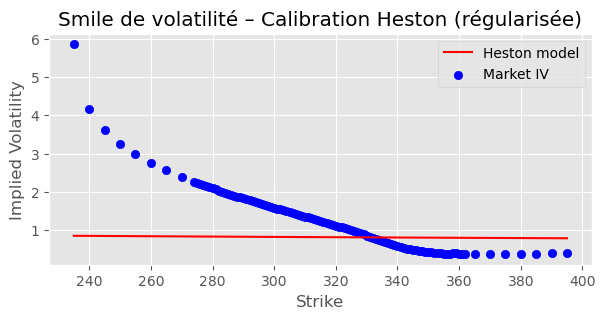

In [ ]:
# IVs calibrées
IV_model = [
    #implied_vol(S0, K, r, T, bs_call_price(S0, K, sigma_opt, r, T))
    implied_vol(S0, K, r, T,conditional_heston_call(K, v0_opt, lambd_opt, a_opt, sigma_opt, rho_opt, S0, T, r, q))
    for K in strikes
]

# Affichage
plt.figure(figsize=(7, 3))
plt.title("Smile de volatilité – Calibration Heston (régularisée)")
plt.xlabel("Strike")
plt.ylabel("Implied Volatility")
plt.plot(strikes, IV_model, label="Heston model", color="red")
plt.scatter(strikes, IV_mkt, label="Market IV", color="blue")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
## Méthode 2, souce article PFE

In [ ]:
def mse_to_minimize(IV_mkt, IV_model):
    #IV_mkt = np.maximum(IV_mkt, 1e-6) # Vu qu'on a des 0 dans l'IV market, pour ne pas divier par 0
    #IV_mkt = np.clip(IV_mkt, 1e-6, None)
    IV_mkt = np.array(IV_mkt)
    IV_model = np.array(IV_model)
    relative_sq_error = ((IV_mkt - IV_model) / IV_mkt) ** 2
    return np.sum(relative_sq_error)

In [ ]:
from scipy.optimize import minimize

# Paramètres du marché
S0 = 334
r = 0.03
q = 0.0
T = 1.0


# Fonction de coût (MSE relative sur les IV)
def objective_function(params, S0, K_array, T, r, q, IV_mkt):
    v, lambd, a, sigma, rho = params

    # Vérification condition de Feller
    if 2 * a < sigma**2:
        return 1e6  # Pénalité énorme si condition violée

    IV_model = []

    for K in K_array:
        call_price = conditional_heston_call(v, S0, K, T, r, q, lambd, a, sigma, rho)
        iv = implied_vol(S0, K, r, T, call_price)
        IV_model.append(iv)

    return mse_to_minimize(IV_mkt, IV_model)


# Paramètres initiaux
v_init = 0.04
lambd_init = 1.0
a_init = 0.04
sigma_init = 0.2
rho_init = -0.5
param_init = np.array([v_init, lambd_init, a_init, sigma_init, rho_init])

# Bornes réalistes
bounds = [
    (0.01, 0.25),     # v
    (0.5, 3.0),       # lambda (plus élevé pour retour plus rapide)
    (0.02, 0.2),      # a (éviter borne inférieure)
    (0.1, 0.8),       # sigma (plus restrictif)
    (-0.8, 0.2)       # rho
]


# Optimisation
result = minimize(
    objective_function,
    x0=param_init,
    #args=(S0, strikes, T, r, q, IV_mkt),
    args=(S0, strikes, T, r, q, IV_mkt),
    method='L-BFGS-B',
    bounds=bounds,
    tol=1e-8
)

print(result)
# Résultats
v_opt, lambd_opt, a_opt, sigma_opt, rho_opt = result.x
print("Résultat de calibration:")
print("v =", v_opt)
print("lambda =", lambd_opt)
print("a =", a_opt)
print("sigma =", sigma_opt)
print("rho =", rho_opt)



  message: ABNORMAL_TERMINATION_IN_LNSRCH
  success: False
   status: 2
      fun: nan
        x: [ 4.000e-02  1.000e+00  4.000e-02  2.000e-01 -5.000e-01]
      nit: 0
      jac: [       nan        nan        nan        nan        nan]
     nfev: 126
     njev: 21
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
Résultat de calibration:
v = 0.04
lambda = 1.0
a = 0.04
sigma = 0.2
rho = -0.5


Résultat de calibration (avec régularisation) :
v = 0.0400
lambda = 1.0000
a = 0.0400
sigma = 0.2000
rho = -0.5000


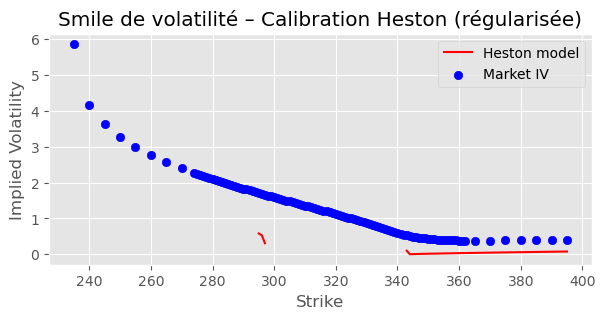

In [ ]:
v_opt, lambd_opt, a_opt, sigma_opt, rho_opt = result.x
print("Résultat de calibration (avec régularisation) :")
print(f"v = {v_opt:.4f}")
print(f"lambda = {lambd_opt:.4f}")
print(f"a = {a_opt:.4f}")
print(f"sigma = {sigma_opt:.4f}")
print(f"rho = {rho_opt:.4f}")

# IVs calibrées
IV_model = [
    #implied_vol(S0, K, r, T, bs_call_price(S0, K, sigma_opt, r, T))
    implied_vol(S0, K, r, T,conditional_heston_call(v, S0, K, T, r, q, lambd, a, sigma, rho))
    for K in strikes
]

# Affichage
plt.figure(figsize=(7, 3))
plt.title("Smile de volatilité – Calibration Heston (régularisée)")
plt.xlabel("Strike")
plt.ylabel("Implied Volatility")
plt.plot(strikes, IV_model, label="Heston model", color="red")
plt.scatter(strikes, IV_mkt, label="Market IV", color="blue")
plt.legend()
plt.grid(True)
plt.show()


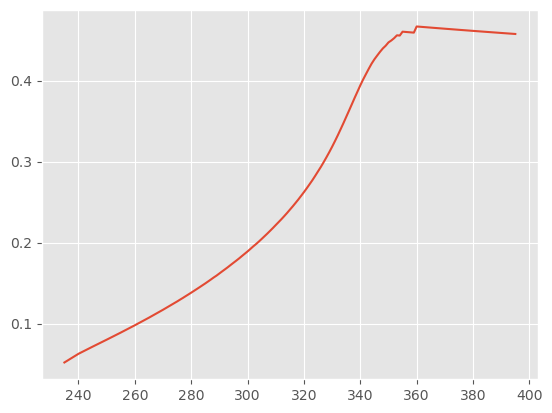

In [ ]:
hestons = [conditional_heston_call(v, S0, K, T, r, q, lambd, a, sigma, rho) for sigma in IV_mkt]
plt.plot(strikes,hestons)

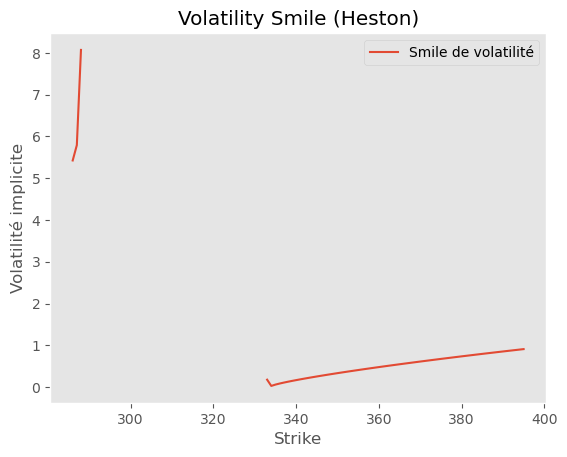

In [ ]:

vols = []
T=0.01
for K in strikes:
    price = conditional_heston_call(v, S0, K, T, r, q, lambd, a, sigma, rho)
    vol_imp = implied_vol(S0, K, r, T, price)
    vols.append(vol_imp)

# === Plot
plt.plot(strikes, vols, label="Smile de volatilité")
plt.xlabel("Strike")
plt.ylabel("Volatilité implicite")
plt.title("Volatility Smile (Heston)")
plt.grid()
plt.legend()
plt.show()